# Plotting stuff from NEID calculations and data

In [759]:
import os
import numpy as np
import pandas as pd
import tamar.tools.plotting_funcs as plot
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.linear_model import LinearRegression
import tamar.tools.utilities as utils
from tamar.tools.settings import CsvDir, ImgDir

Read in velocities from csv.

In [760]:
# csv file with rv components
csv_file = os.path.join(CsvDir.NEID_CALC, 'rvs_from_fits.csv')
# csv_file = os.path.join(CsvDir.NEID_CALC, 'rvs_from_txt.csv')

Get component lists.

In [761]:
# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get dates list
date_jd = component_df.date_jd.values
inds = np.argsort(date_jd)

print(date_jd[-1])

2459390.0


Remove bad RVs (outlier).

In [762]:
rv_sun = component_df.rv_sun.values[inds]
rv_error = component_df.rv_error.values[inds]
# print(rv_sun)

In [763]:
non_nan = np.logical_not(np.isnan(rv_sun))

rv_med = np.nanmedian(np.abs(rv_sun))

good_sun = np.logical_and(np.abs(rv_sun) > rv_med - 2, np.abs(rv_sun) < rv_med + 2)
good_error = np.logical_and(np.abs(rv_error) < .4, np.abs(rv_error)  < .4)
good = np.logical_and(good_sun, good_error)

good_rvs = np.logical_and(good, non_nan)

In [764]:
# get velocities lists
v_phot = component_df.v_phot.values[inds][good_rvs]
v_conv = component_df.v_conv.values[inds][good_rvs]
rv_model = component_df.rv_model.values[inds][good_rvs]
# rv_model = component_df.rv_model.values[inds][good_rvs]
rv_sun = rv_sun[good_rvs]
rv_error = rv_error[good_rvs]
v_quiet = component_df.v_quiet.values[inds][good_rvs]
v_disc = component_df.v_disc.values[inds][good_rvs]

# get magnetic observables
f = component_df.f.values[inds][good_rvs]
Bobs = component_df.Bobs.values[inds][good_rvs]
f_bright = component_df.f_bright.values[inds][good_rvs]
f_spot = component_df.f_spot.values[inds][good_rvs]

# dates
date_jd = date_jd[inds][good_rvs]
dates = component_df.date_obs.values[inds][good_rvs]
print(dates[-1])

2021-06-21T12:00:00


# Plotting for entire timeframe

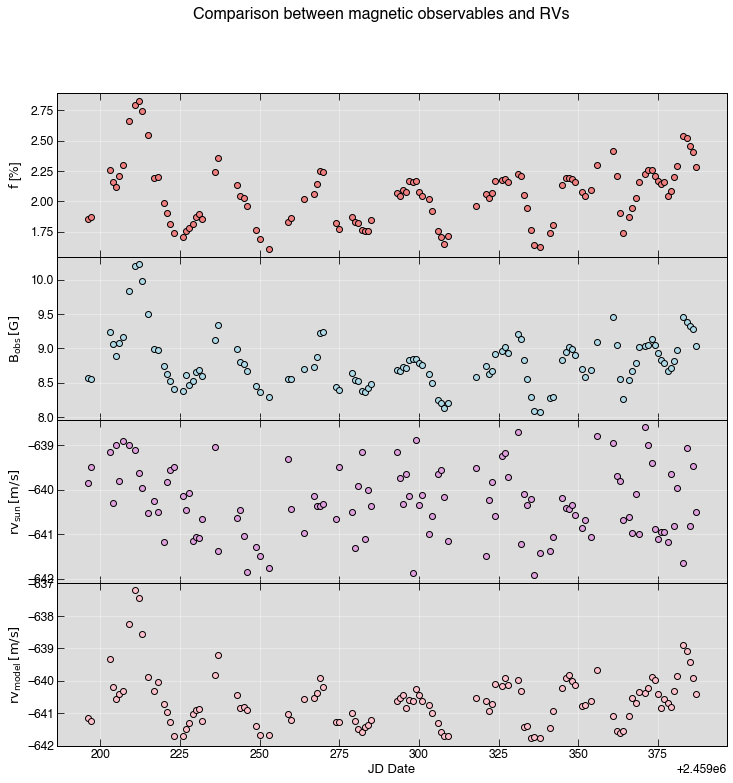

In [765]:
x = date_jd
y_list = [f, Bobs, rv_sun, rv_model]
xlabel = 'JD Date'
ylabel_list = [r'$\rm f$ [%]', r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$',  r'$\rm rv_{\rm model}\/\rm [m/s]$']
title = 'Comparison between magnetic observables and RVs'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_mag_rv.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

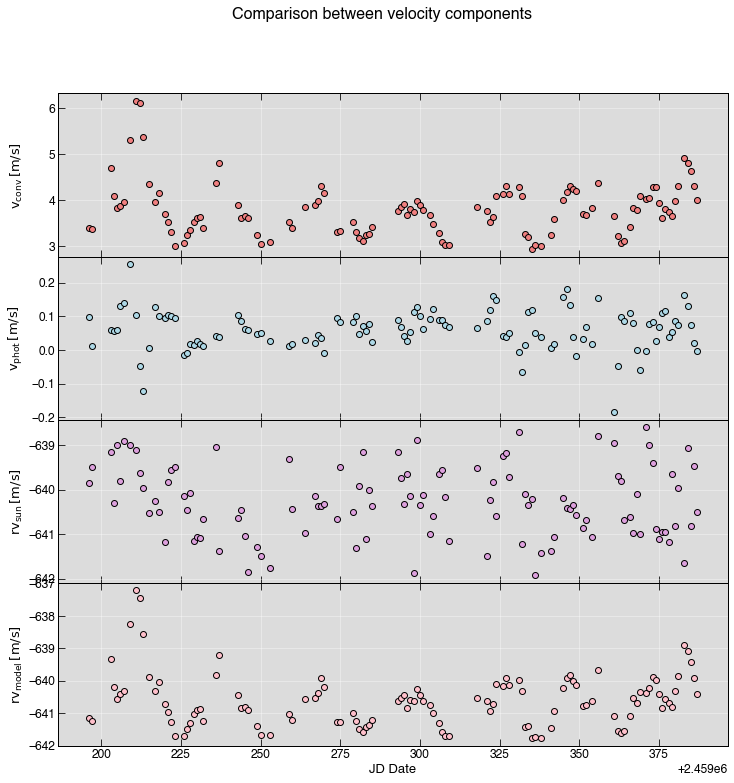

In [766]:
x = date_jd
y_list = [v_conv, v_phot, rv_sun, rv_model]
xlabel = 'JD Date'
ylabel_list = [r'$\rm v_{\rm conv}\/\rm [m/s]$', r'$\rm v_{\rm phot}\/\rm [m/s]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$',
               r'$\rm rv_{\rm model}\/\rm [m/s]$']
title = 'Comparison between velocity components'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_vel.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

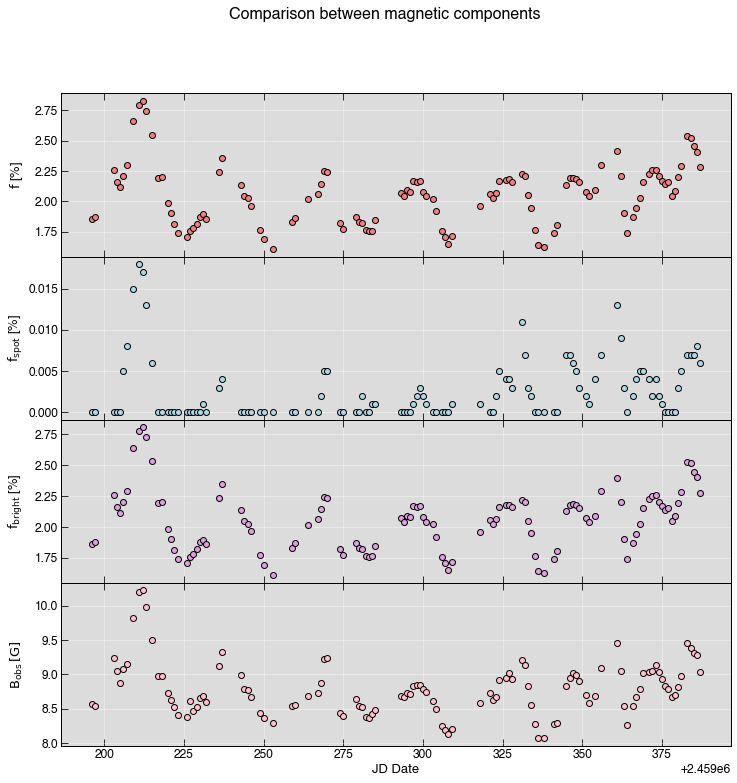

In [767]:
x = date_jd
y_list = [f, f_spot, f_bright, Bobs]
xlabel = 'JD Date'
ylabel_list = [r'$\rm f$ [%]', r'$\rm f_{\rm spot}$ [%]', r'$\rm f_{\rm bright}$ [%]',
               r'$\rm B_{\rm obs}\/\rm [G]$']
title = 'Comparison between magnetic components'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_mag.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

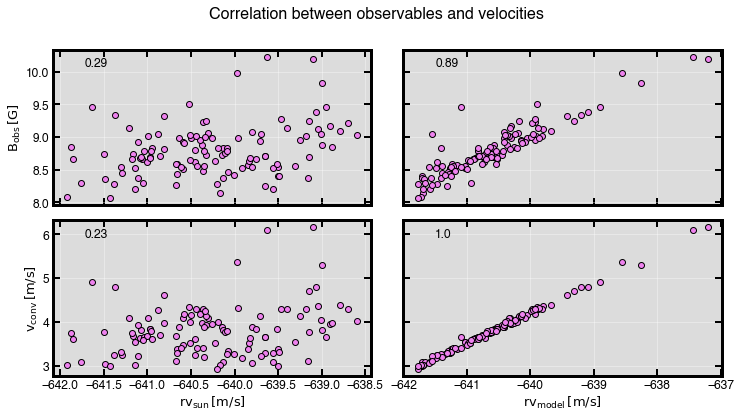

In [768]:
x_list = [rv_sun, rv_model]
y_list = [Bobs, v_conv]
title = 'Correlation between observables and velocities'
xlabel_list = [r'$\rm rv_{\rm sun}\/\rm [m/s]$', r'$\rm rv_{\rm model}\/\rm [m/s]$']
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm v_{\rm conv}\/\rm [m/s]$']

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_vel_mag.png')
plot.four_correlation_plots(x_list, y_list, title, xlabel_list, ylabel_list, save_fig)


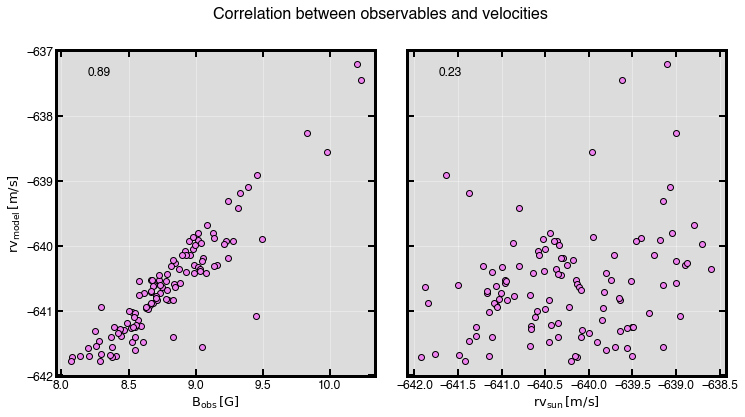

In [769]:
x_list = [Bobs, rv_sun]
y_list = rv_model
title = 'Correlation between observables and velocities'
xlabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$']
ylabel_list = r'$\rm rv_{\rm model}\/\rm [m/s]$'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rv_mag.png')
plot.two_correlation_plots(x_list, y_list, title, xlabel_list, ylabel_list, save_fig)


# Plot Periodogram

In [770]:
from scipy.signal import lombscargle

In [771]:
rv = rv_model
jd = date_jd

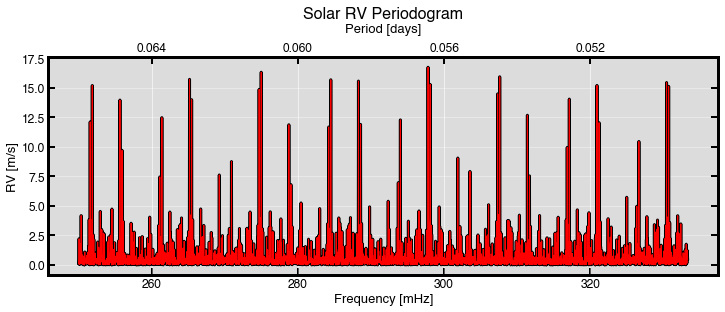

In [772]:
# rough time sampling
djd = np.median(np.diff(jd)) # days
djd_s = djd # * 24. # * 3600. # seconds
djd_hz = 1. / djd_s # hz
freqs = np.linspace(djd_hz / 4, djd_hz/3., 3500)
#freqs = np.linspace(2.75e-3, 3.5e-3, 2500)
drv = (rv - np.mean(rv))
jd_s = (jd - min(jd)) * 24. * 3600.
#inds_snr = np.where((snr > thresh_snr) & (np.abs(rv - np.median(rv)) < thresh_rv)) # & (jd > 2.459277e6))
ls = lombscargle(jd_s, drv, freqs)
def tick_function(X):
    V = (1./ (X * 1e-3)) * 1/60.
    return ['%.3f' % z for z in V]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
xvals = freqs * 1e3
data = ls
ax1.plot(xvals, data, 'k',lw=2,alpha=0)
ax1.plot(xvals, data, 'r',lw=0.5,alpha=0)
ax1Ticks = ax1.get_xticks()
ax2Ticks = ax1Ticks
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax2Ticks))
ax1.set_xlabel('Frequency [mHz]')
ax2.set_xlabel('Period [days]', labelpad=10)
ax1.set_ylabel('RV [m/s]')
ax1.grid(True)
ax2.plot(xvals, data, 'k',lw=3)
ax2.plot(xvals, data, 'r',lw=1.)
title = ax1.set_title('Solar RV Periodogram')
title.set_y(1.2)
plt.show()

# Subtract unsigned flux

In [773]:
X = Bobs.reshape(-1, 1)
Y = rv_sun
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*Bobs + b
rv_Bobs = rv_sun - fit_line

0.7968775481348341
0.7536266185873703


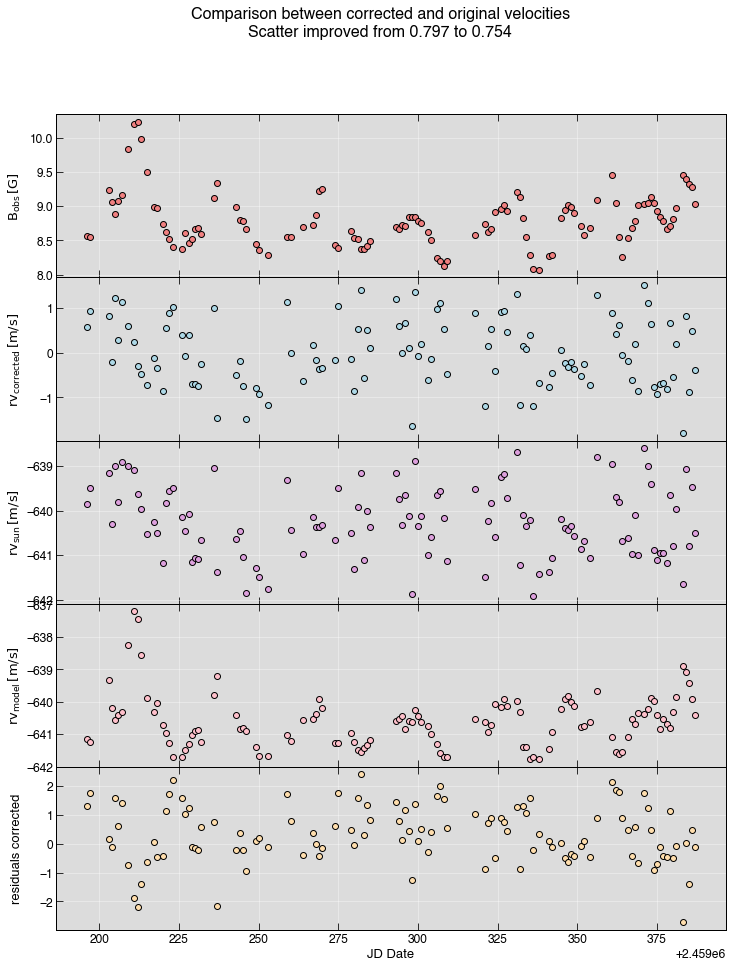

In [774]:
x = date_jd
y_list = [Bobs, rv_Bobs, rv_sun, rv_model, rv_sun - rv_model]
xlabel = 'JD Date'
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm rv_{\rm corrected}\/\rm [m/s]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$',
               r'$\rm rv_{\rm model}\/\rm [m/s]$', 'residuals corrected']
title = 'Comparison between corrected and original velocities\nScatter improved from ' + str(np.round(np.std(rv_sun), 3)) + ' to ' + str(np.round(np.std(rv_Bobs), 3))

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_velcor_mag.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None
print(np.std(rv_sun))
print(np.std(rv_Bobs))

# Good Weather Cut

In [775]:
bad_days_csv = os.path.join(CsvDir.NEID_DATA, 'pyr_quality_by_day.csv')

save_fig = None

In [776]:
# create pandas dataframe
quality_df = pd.read_csv(bad_days_csv)

# get dates
qual_dates = quality_df.DATE.values
quality = quality_df.QUAL.values

In [777]:
# make dates compatible
times = [str(d)[0:4] + "-" + str(d)[4:6] + '-' + str(d)[6:8] + 'T12:00:00' for d in qual_dates]
dt = [utils.get_dates(d) for d in times]
date_str = [d[0] for d in dt]
date_obj = [d[1] for d in dt]
jd = [d[2].value for d in dt]

In [778]:
# get good times

good_days = np.where(quality < 2, jd, None)
good_days = list(filter(None, list(good_days)))
neid_inds = np.isin(date_jd, good_days)

In [779]:
g_v_phot = v_phot[neid_inds]
g_v_conv = v_conv[neid_inds]
g_rv_sun = rv_sun[neid_inds]
g_rv_model = rv_model[neid_inds]
g_f = f[neid_inds]
g_f_spot = f_spot[neid_inds]
g_f_bright = f_bright[neid_inds]
g_Bobs= Bobs[neid_inds]
g_dates = dates[neid_inds]
g_date_jd = date_jd[neid_inds]
g_days_range = range(0, len(dates))

In [780]:
print(g_dates)

['2020-12-19T12:00:00' '2020-12-20T12:00:00' '2021-01-05T12:00:00'
 '2021-01-12T12:00:00' '2021-01-15T12:00:00' '2021-02-04T12:00:00'
 '2021-02-07T12:00:00' '2021-02-18T12:00:00' '2021-02-21T12:00:00'
 '2021-02-22T12:00:00' '2021-03-05T12:00:00' '2021-04-02T12:00:00'
 '2021-04-03T12:00:00' '2021-04-17T12:00:00' '2021-04-19T12:00:00'
 '2021-04-23T12:00:00' '2021-04-29T12:00:00' '2021-04-30T12:00:00'
 '2021-05-03T12:00:00' '2021-05-07T12:00:00' '2021-05-10T12:00:00'
 '2021-05-11T12:00:00' '2021-05-12T12:00:00' '2021-05-16T12:00:00'
 '2021-05-19T12:00:00' '2021-05-27T12:00:00' '2021-05-31T12:00:00'
 '2021-06-03T12:00:00' '2021-06-05T12:00:00' '2021-06-06T12:00:00'
 '2021-06-11T12:00:00' '2021-06-12T12:00:00']


## Plotting for good weather

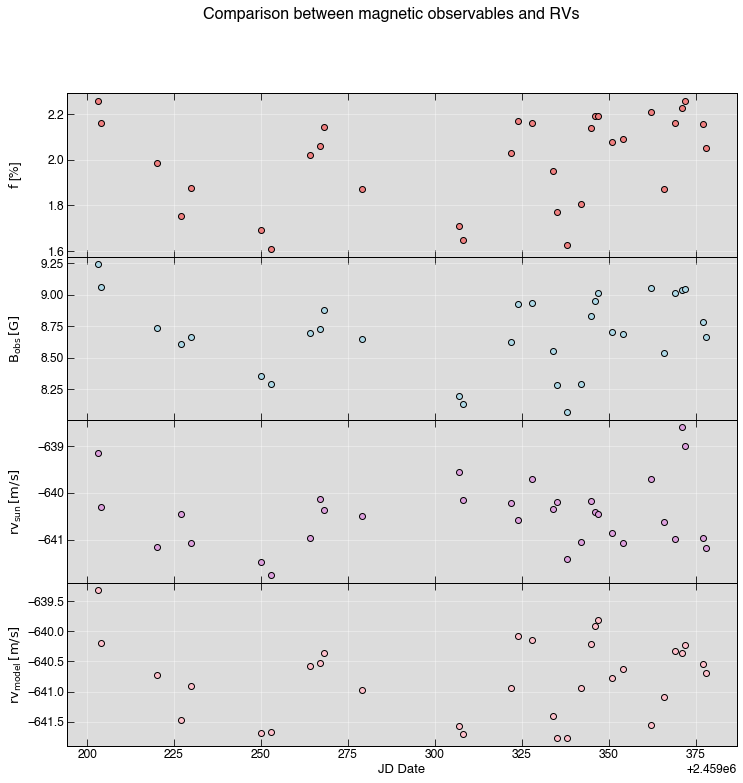

In [781]:
x = g_date_jd
y_list = [g_f, g_Bobs, g_rv_sun, g_rv_model]
xlabel = 'JD Date'
ylabel_list = [r'$\rm f$ [%]', r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$',  r'$\rm rv_{\rm model}\/\rm [m/s]$']
title = 'Comparison between magnetic observables and RVs'

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_timeseries_mag_rv.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

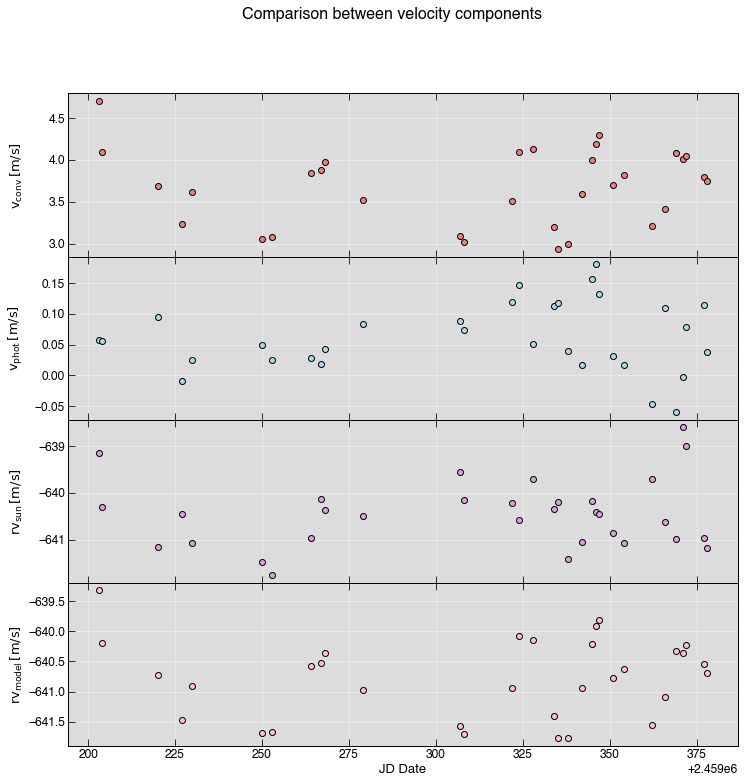

In [782]:
x = g_date_jd
y_list = [g_v_conv, g_v_phot, g_rv_sun, g_rv_model]
xlabel = 'JD Date'
ylabel_list = [r'$\rm v_{\rm conv}\/\rm [m/s]$', r'$\rm v_{\rm phot}\/\rm [m/s]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$',
               r'$\rm rv_{\rm model}\/\rm [m/s]$']
title = 'Comparison between velocity components'

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_timeseries_vel.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

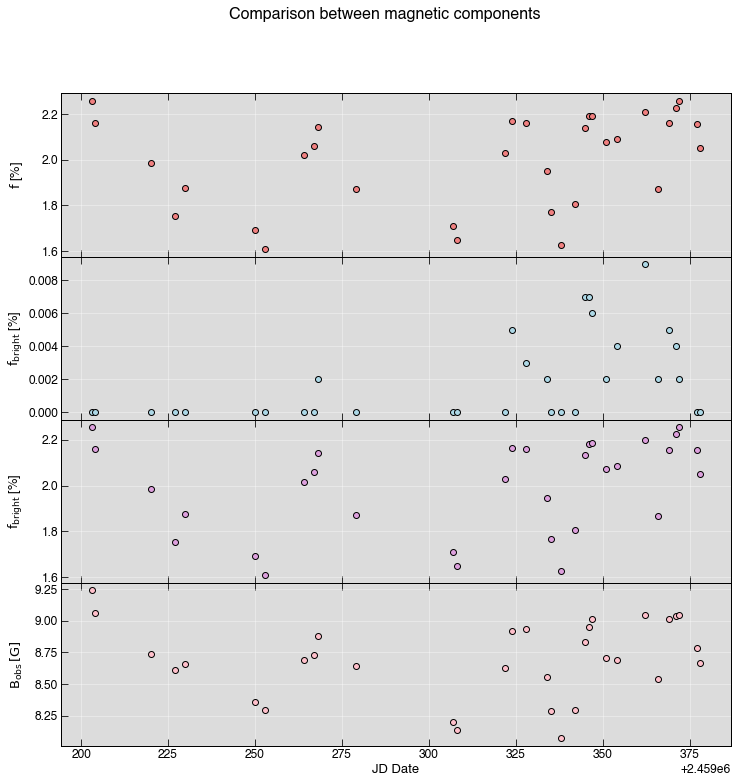

In [783]:
x = g_date_jd
y_list = [g_f, g_f_spot, g_f_bright, g_Bobs]
xlabel = 'JD Date'
ylabel_list = [r'$\rm f$ [%]', r'$\rm f_{\rm spot}$ [%]', r'$\rm f_{\rm bright}$ [%]',
               r'$\rm B_{\rm obs}\/\rm [G]$']
title = 'Comparison between magnetic components'

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_timeseries_mag.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

# Subtract unsigned flux

In [784]:
X = g_Bobs.reshape(-1, 1)
Y = g_rv_sun
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*g_Bobs + b
g_rv_Bobs = g_rv_sun - fit_line

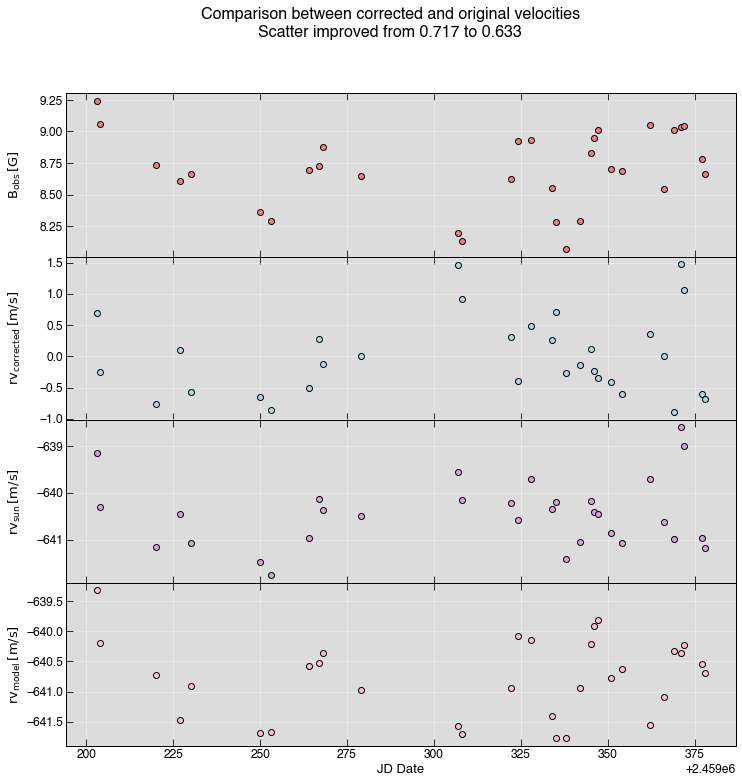

In [785]:
x = g_date_jd
y_list = [g_Bobs, g_rv_Bobs, g_rv_sun, g_rv_model]
xlabel = 'JD Date'
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm rv_{\rm corrected}\/\rm [m/s]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$',
               r'$\rm rv_{\rm model}\/\rm [m/s]$']
title = 'Comparison between corrected and original velocities\nScatter improved from ' + str(np.round(np.std(g_rv_sun), 3)) + ' to ' + str(np.round(np.std(g_rv_Bobs), 3))

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_timeseries_velcor_mag.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

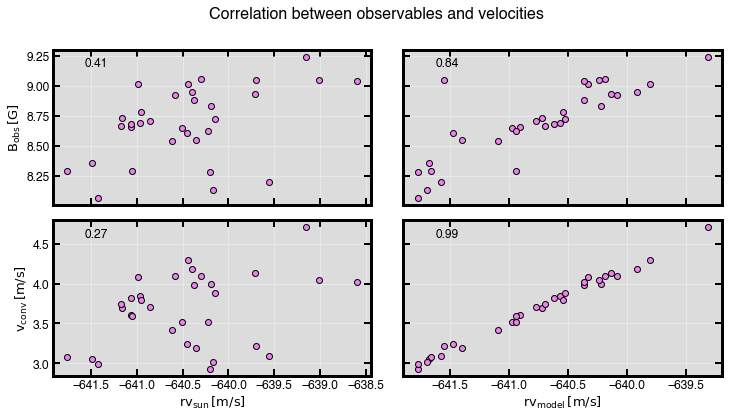

In [786]:
x_list = [g_rv_sun, g_rv_model]
y_list = [g_Bobs, g_v_conv]
title = 'Correlation between observables and velocities'
xlabel_list = [r'$\rm rv_{\rm sun}\/\rm [m/s]$', r'$\rm rv_{\rm model}\/\rm [m/s]$']
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm v_{\rm conv}\/\rm [m/s]$']

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_correlation_vel_mag.png')
plot.four_correlation_plots(x_list, y_list, title, xlabel_list, ylabel_list, save_fig)


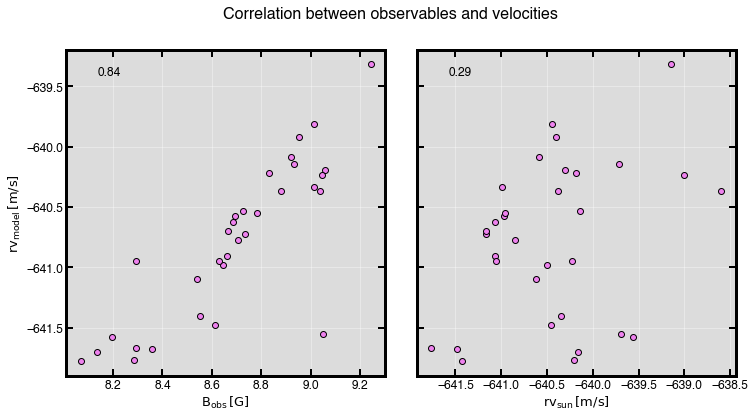

In [787]:
x_list = [g_Bobs, g_rv_sun]
y_list = g_rv_model
title = 'Correlation between observables and velocities'
xlabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm rv_{\rm sun}\/\rm [m/s]$']
ylabel_list = r'$\rm rv_{\rm model}\/\rm [m/s]$'

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_correlation_rv_mag.png')
plot.two_correlation_plots(x_list, y_list, title, xlabel_list, ylabel_list, save_fig)

# This is chaotic and way too many unnecessary plots!!!!

In [788]:
# good_inds = np.where(dates != '2021-01-11T12:00:00.00')
# v_phot = v_phot[good_inds]
# v_conv = v_conv[good_inds]
# rv_sun = rv_sun[good_inds]
# rv_model = rv_model[good_inds]
# f = f[good_inds]
# Bobs= Bobs[good_inds]
# dates = dates[good_inds]
# date_jd = date_jd[good_inds]
# days_range = range(0, len(dates))

In [789]:
# print(dates)

In [790]:
# don't save figures for now
save_fig = None

## Magnetic Observable Comparisons

Comparison plot of magnetic observables.

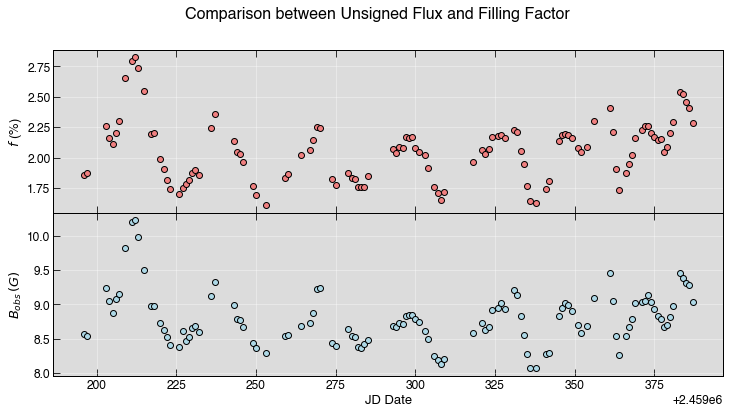

In [791]:
x = date_jd
y_list = [f, Bobs]
xlabel = 'JD Date'
ylabel_list = ['$f$ (%)', '$B_{obs}\/ (G)$']
title = 'Comparison between Unsigned Flux and Filling Factor'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_f_Bobs.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

Correlation plot between unsigned flux and filling factor.

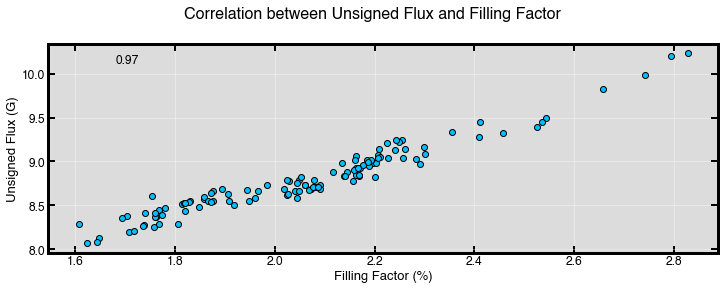

In [792]:
x = f
y = Bobs
xlabel = 'Filling Factor (%)'
ylabel = 'Unsigned Flux (G)'
title = 'Correlation between Unsigned Flux and Filling Factor'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_f_Bobs.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

## Filling Factor and NEID RV Comparison

Compare NEID RVs to filling factor.

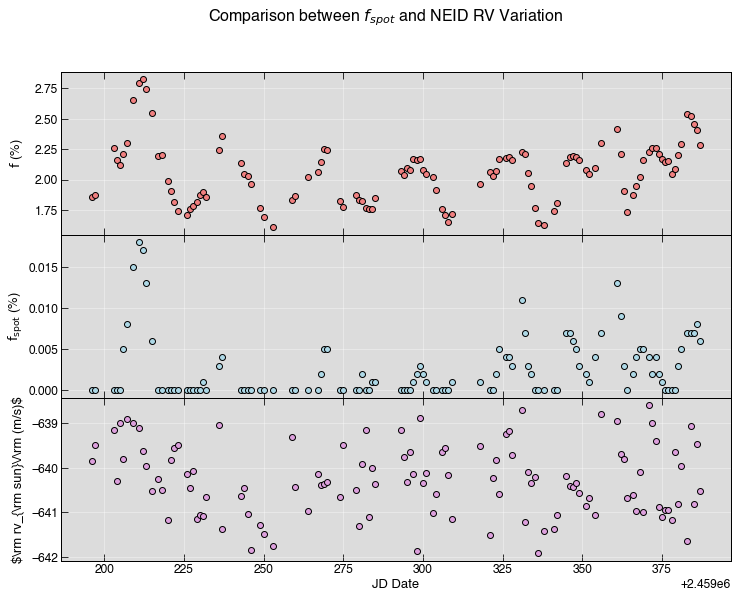

In [793]:
x = date_jd
y_list = [f, f_spot, rv_sun]
xlabel = 'JD Date'
ylabel_list = [r'$\rm f$ (%)', r'$\rm f_{\rm spot}$ (%)', r'\$\rm rv_{\rm sun}\/\rm (m/s)$']
title = 'Comparison between $f_{spot}$ and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rvsun_f.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None


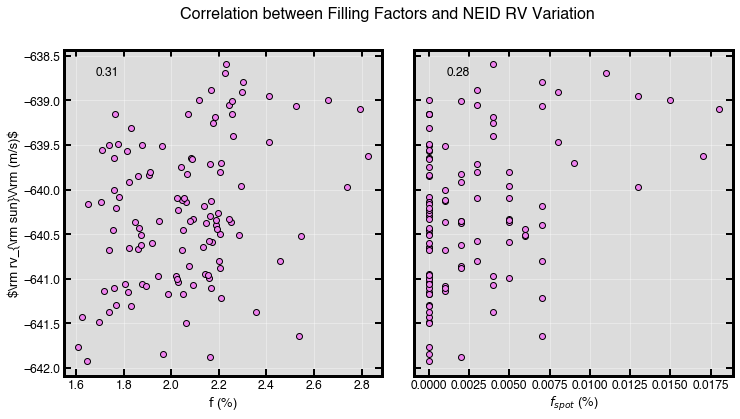

In [794]:
x_list = [f, f_spot]
y = rv_sun
xlabel_list = [r'$\rm f$ (%)', '$f_{spot}$ (%)']
ylabel = r'\$\rm rv_{\rm sun}\/\rm (m/s)$'
title = 'Correlation between Filling Factors and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvsun_Bobs.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

## Compare NEID RVs to unsigned flux.

Compare NEID RVs to unsigned flux.

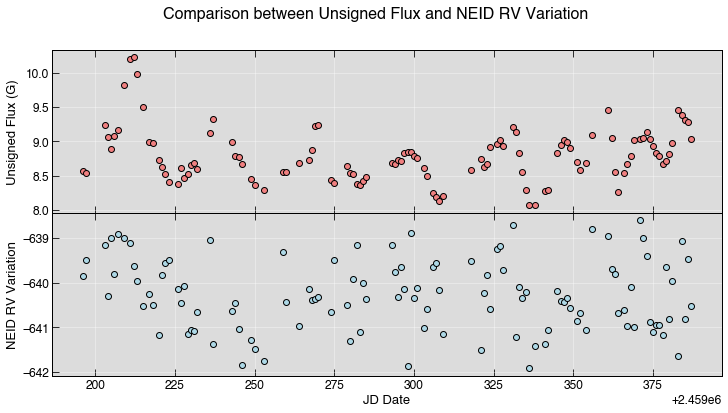

In [795]:
x = date_jd
y_list = [Bobs, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Unsigned Flux (G)', 'NEID RV Variation']
title = 'Comparison between Unsigned Flux and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rvsun_Bobs.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig=None

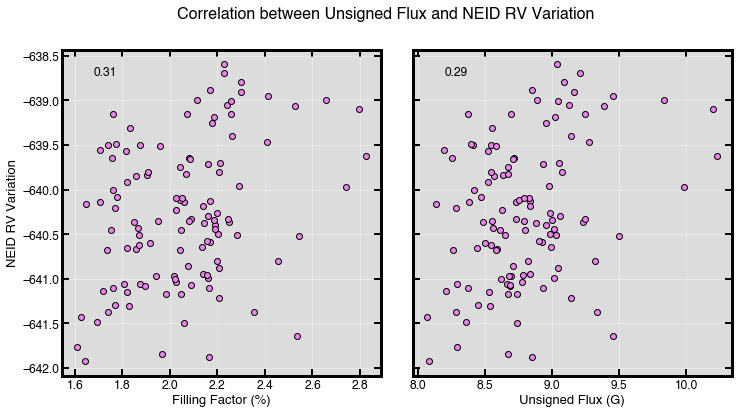

In [796]:
x_list = [f, Bobs]
y = rv_sun
xlabel_list = ['Filling Factor (%)', 'Unsigned Flux (G)']
ylabel = 'NEID RV Variation'
title = 'Correlation between Unsigned Flux and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvsun_Bobs.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

# Subtract unsigned flux

In [797]:
X = Bobs.reshape(-1, 1)
Y = rv_sun
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*Bobs + b
rv_Bobs = rv_sun - fit_line

print('Edited RV STD:', np.std(rv_Bobs))
print('NEID RV STD:', np.std(rv_sun))

Edited RV STD: 0.7536266185873703
NEID RV STD: 0.7968775481348341


Text(0.5, 1.0, 'Comparison of $B_{obs}$ and NEID RV')

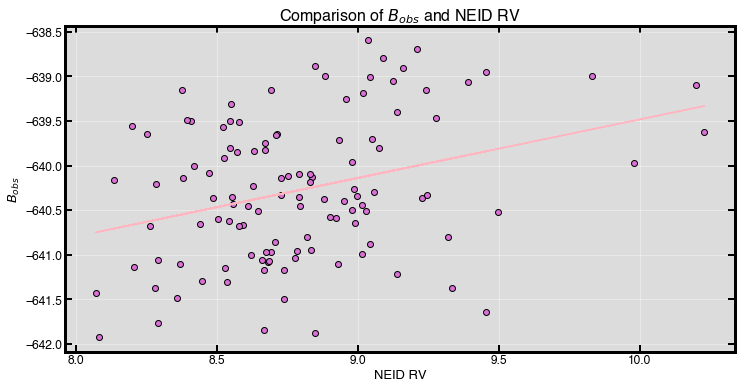

In [798]:
plt.scatter(Bobs, rv_sun, color='orchid', edgecolor='k', linewidths=1.0)
plt.plot(Bobs, fit_line, color='lightpink')
plt.xlabel('NEID RV')
plt.ylabel('$B_{obs}$')
plt.title('Comparison of $B_{obs}$ and NEID RV')

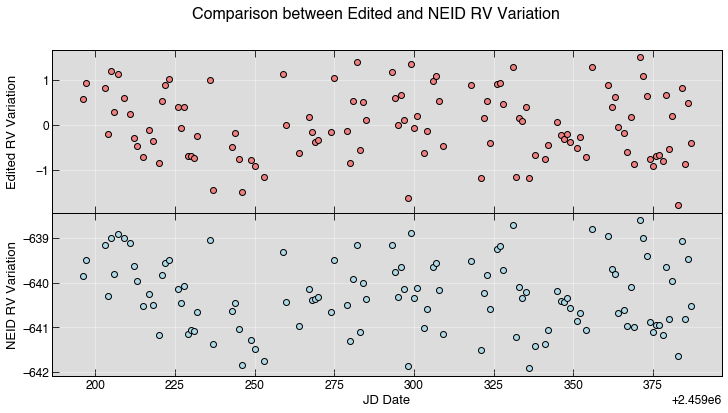

In [799]:
x = date_jd
y_list = [rv_Bobs, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Edited RV Variation', 'NEID RV Variation']
title = 'Comparison between Edited and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_grad_reg.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

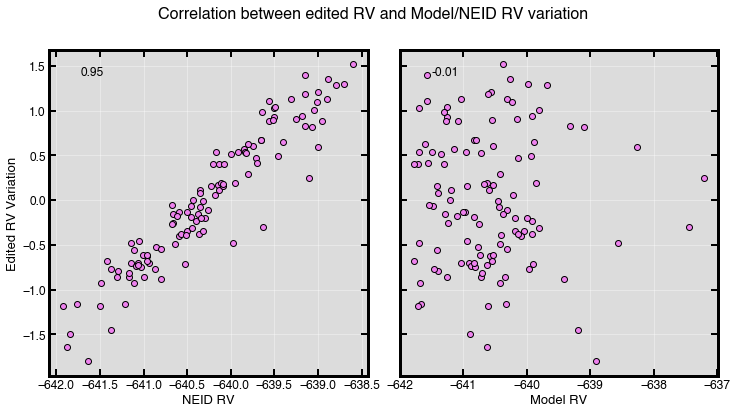

In [800]:
x_list = [rv_sun, rv_model]
y = rv_Bobs
title = 'Correlation between edited RV and Model/NEID RV variation'
xlabel_list = ['NEID RV', 'Model RV']
ylabel = 'Edited RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvmodel_f_Bobs.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

# Compare with Model RVs

## NEID RVs and Model RVs

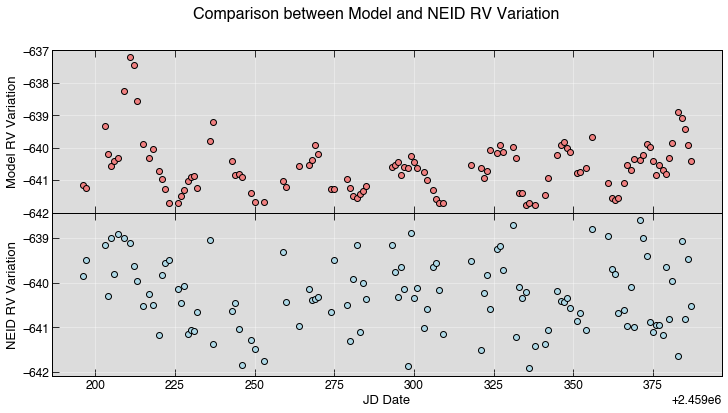

In [801]:
x = date_jd
y_list = [rv_model, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'NEID RV Variation']
title = 'Comparison between Model and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_grad_reg.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

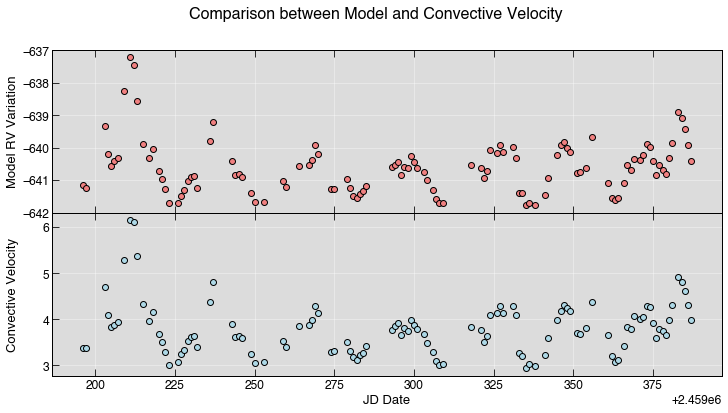

In [802]:
x = date_jd
y_list = [rv_model, v_conv]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'Convective Velocity']
title = 'Comparison between Model and Convective Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rvmodel_vconv.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

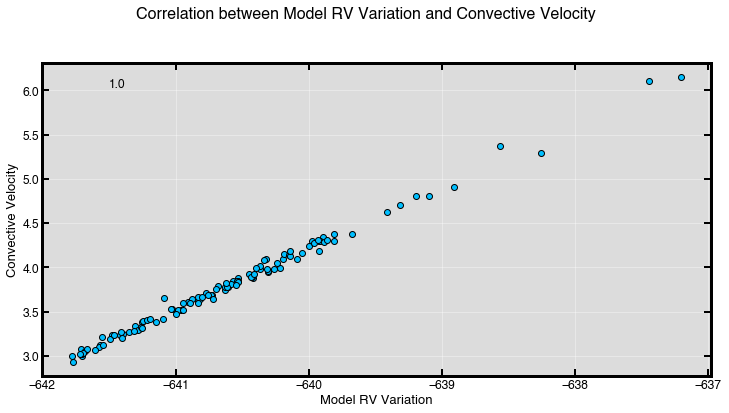

In [803]:
x = rv_model
y = v_conv
xlabel = 'Model RV Variation'
ylabel = 'Convective Velocity'
title = 'Correlation between Model RV Variation and Convective Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvmodel_vconv.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

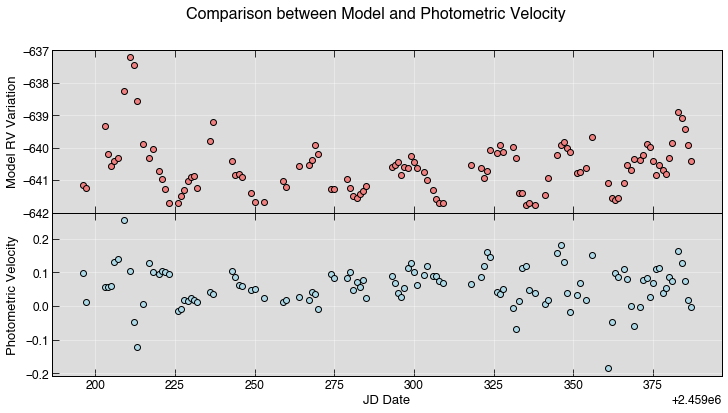

In [804]:
x = date_jd
y_list = [rv_model, v_phot]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'Photometric Velocity']
title = 'Comparison between Model and Photometric Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rvmodel_vphot.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

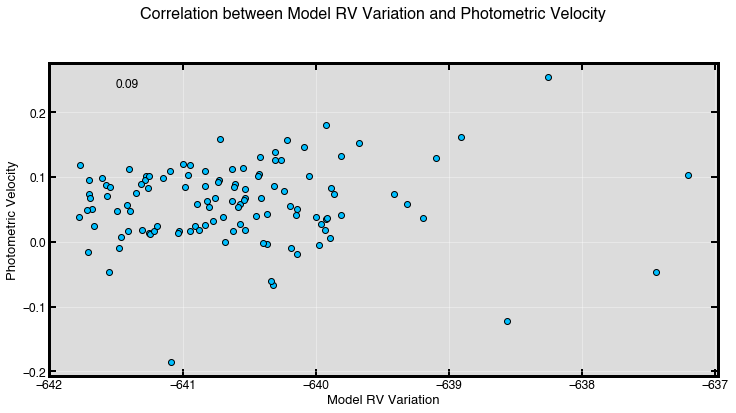

In [805]:
x = rv_model
y = v_phot
xlabel = 'Model RV Variation'
ylabel = 'Photometric Velocity'
title = 'Correlation between Model RV Variation and Photometric Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvmodel_vphot.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None


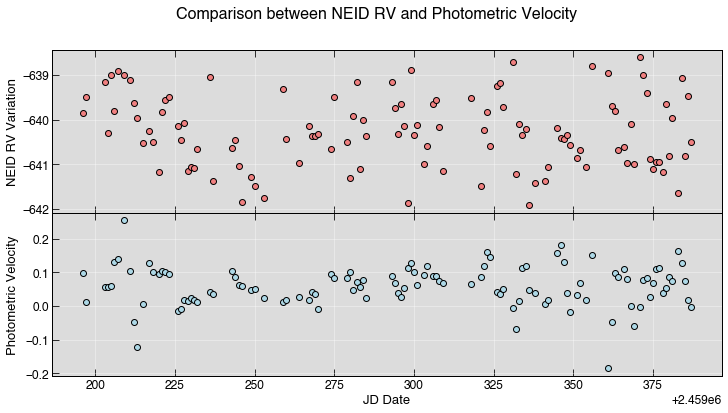

In [806]:
x = date_jd
y_list = [rv_sun, v_phot]
xlabel = 'JD Date'
ylabel_list = ['NEID RV Variation', 'Photometric Velocity']
title = 'Comparison between NEID RV and Photometric Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rvsun_vphot.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None


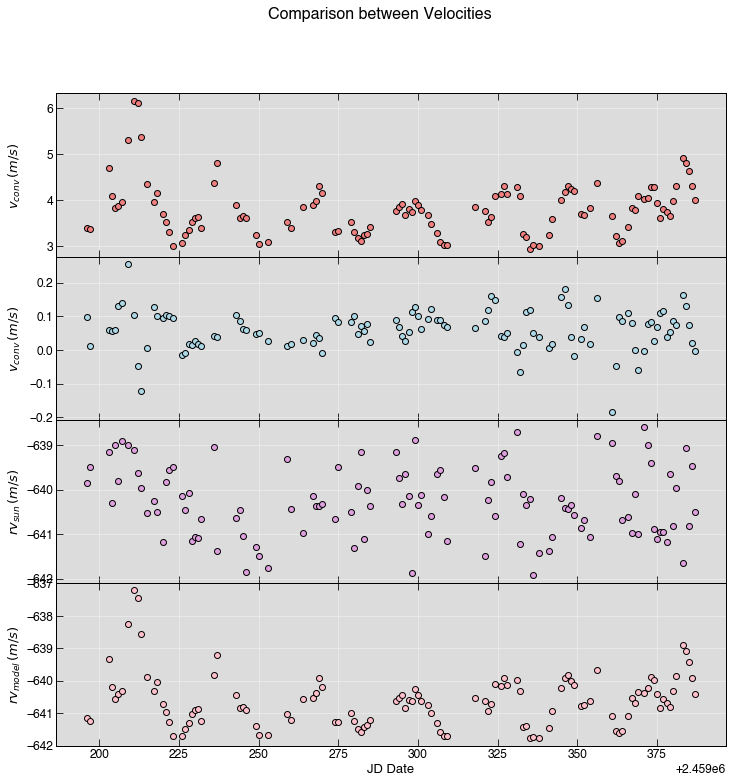

In [807]:
x = date_jd
y_list = [v_conv, v_phot, rv_sun, rv_model]
xlabel = 'JD Date'
ylabel_list = ['$v_{conv} \/(m/s)$','$v_{conv} \/(m/s)$', '$rv_{sun} \/(m/s)$', '$rv_{model} \/(m/s)$']
title = 'Comparison between Velocities'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_vel.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

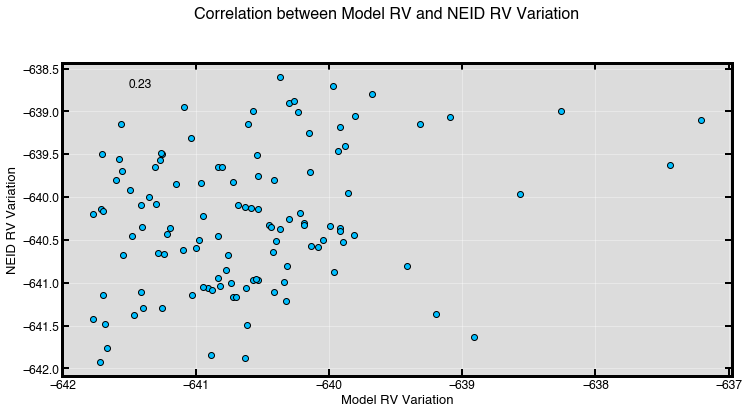

In [808]:
x = rv_model
y = rv_sun
xlabel = 'Model RV Variation'
ylabel = 'NEID RV Variation'
title = 'Correlation between Model RV and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvmodel_rvsun.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

## Look at full disc and quiet-Sun velocity

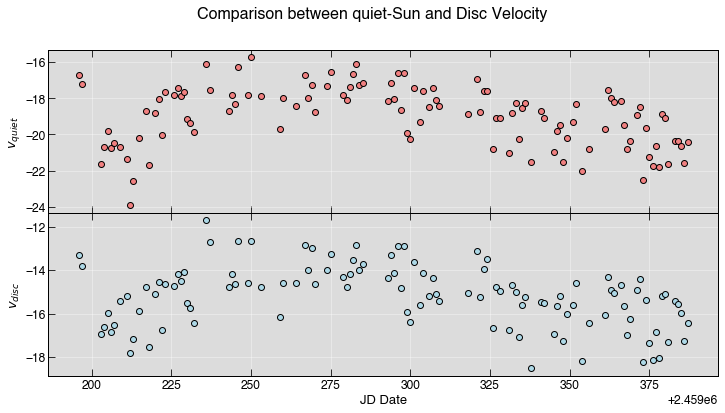

In [809]:
x = date_jd
y_list = [v_quiet, v_disc]
xlabel = 'JD Date'
ylabel_list = ['$v_{quiet}$', '$v_{disc}$']
title = 'Comparison between quiet-Sun and Disc Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rvsun_vphot.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

## Comparison with observables

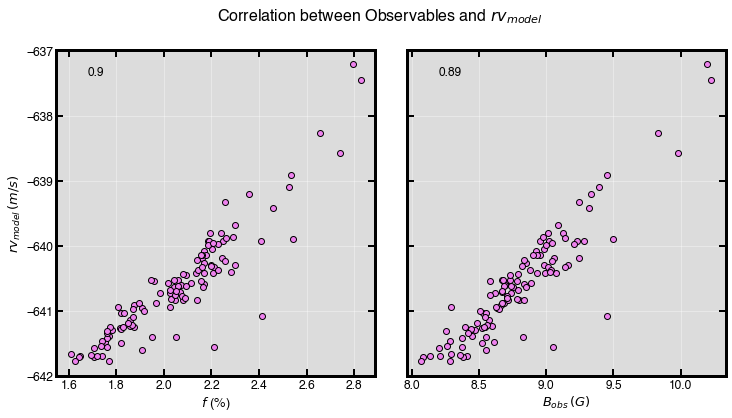

In [810]:
x_list = [f, Bobs]
y = rv_model
title = 'Correlation between Observables and $rv_{model}$'
xlabel_list = ['$f$ (%)', '$B_{obs}\/ (G)$']
ylabel = '$rv_{model} \/(m/s)$'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvmodel_f_Bobs.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

## RV and Velocities comparison

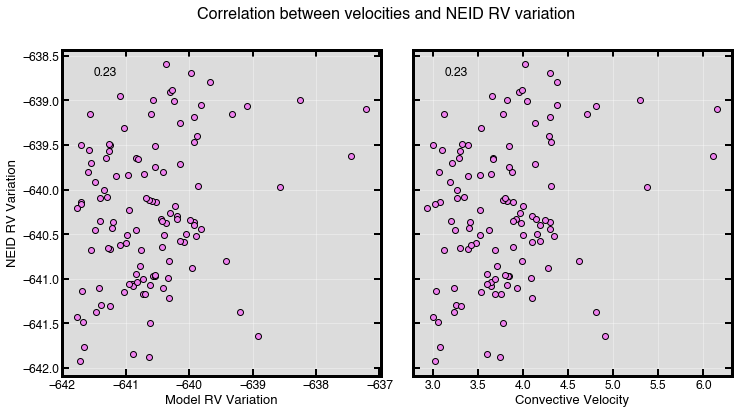

In [811]:
x_list = [rv_model, v_conv]
y = rv_sun
title = 'Correlation between velocities and NEID RV variation'
xlabel_list = ['Model RV Variation', 'Convective Velocity']
ylabel = 'NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_rvsun_rvmodel_vconv.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig=None)
save_fig = None



## Observables comparison with convective velocity

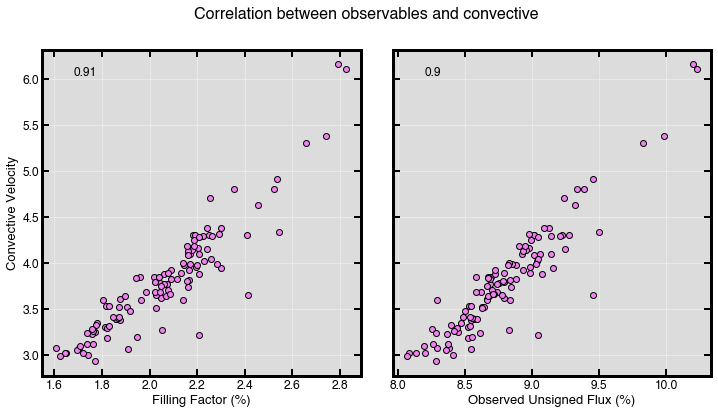

In [812]:
x_list = [f, Bobs]
y = v_conv
title = 'Correlation between observables and convective'
xlabel_list = ['Filling Factor (%)', 'Observed Unsigned Flux (%)']
ylabel = 'Convective Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_vconv_f_Bobs.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

Overplotting of RVs

In [813]:
x = date_jd
y_list = [rv_sun, rv_model]
xlabel = 'JD Date'
ylabel_list = ['RV Sun', 'RV Model']
title = 'Comparison of RV from NEID and Model'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_grad_reg.png')
# plot.plot_overlaid_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

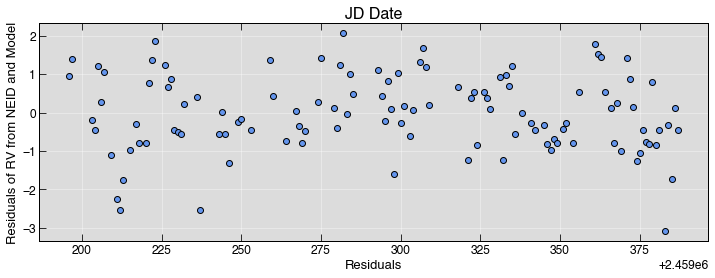

In [814]:
x = date_jd
y = rv_sun - np.median(rv_sun) - rv_model - np.median(rv_model)
y -= np.median(y)
xlabel = 'JD Date'
ylabel = 'Residuals'
title = 'Residuals of RV from NEID and Model'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_rv_residuals.png')
plot.plot_timeseries(x, y, xlabel, ylabel, title, save_fig)
save_fig = None

## Plot histograms of RV data

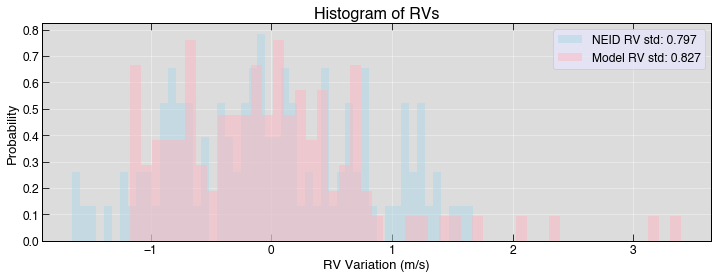

In [815]:
import matplotlib.pyplot as plt
sun_hist = rv_sun - np.average(rv_sun)
model_hist = rv_model - np.average(rv_model)
sun_std = np.std(sun_hist)
model_std = np.std(model_hist)
plt.hist(sun_hist, color='lightblue', alpha=0.5, label='NEID RV std: ' + str(np.round(sun_std, 3)), density=True, bins=50)
plt.hist(model_hist, color='lightpink', alpha=0.5, label='Model RV std: ' + str(np.round(model_std, 3)), density=True, bins=50)
plt.title('Histogram of RVs')
plt.xlabel('RV Variation (m/s)')
plt.ylabel('Probability')
plt.legend()
plt.show()


# Remove bad days

In [816]:
bad_days_csv = os.path.join(CsvDir.NEID_DATA, 'pyr_quality_by_day.csv')

save_fig = None

In [817]:
# create pandas dataframe
quality_df = pd.read_csv(bad_days_csv)

# get dates
qual_dates = quality_df.DATE.values
quality = quality_df.QUAL.values

In [818]:
import tamar.tools.utilities as utils
# make dates compatible
times = [str(d)[0:4] + "-" + str(d)[4:6] + '-' + str(d)[6:8] + 'T12:00:00' for d in qual_dates]
dt = [utils.get_dates(d) for d in times]
date_str = [d[0] for d in dt]
date_obj = [d[1] for d in dt]
jd = [d[2].value for d in dt]

In [819]:
# get good days = np.logical_and(quality < 2, np.isin(times, dates))

In [820]:
# get good times

good_days = np.where(quality < 2, jd, None)
good_days = list(filter(None, list(good_days)))
# good_days = times[good_times]

Now we do the RV comparisons for just the clear days.

Get the good data.

In [821]:
neid_inds = np.isin(date_jd, good_days)

# print(date_jd)
# print(good_days)

In [822]:
g_v_phot = v_phot[neid_inds]
g_v_conv = v_conv[neid_inds]
g_rv_sun = rv_sun[neid_inds]
g_rv_model = rv_model[neid_inds]
g_f = f[neid_inds]
g_f_spot = f_spot[neid_inds]
g_Bobs= Bobs[neid_inds]
g_dates = dates[neid_inds]
g_date_jd = date_jd[neid_inds]
g_days_range = range(0, len(dates))

## Good days plotting

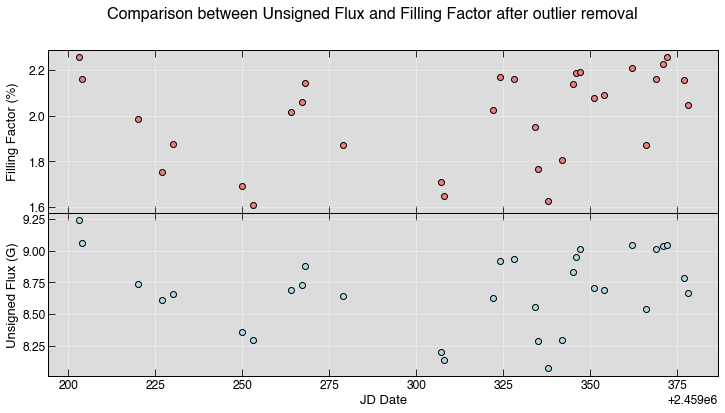

In [823]:
x = g_date_jd
y_list = [g_f, g_Bobs]
xlabel = 'JD Date'
ylabel_list = ['Filling Factor (%)', 'Unsigned Flux (G)']
title = 'Comparison between Unsigned Flux and Filling Factor after outlier removal'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_f_Bobs.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

Correlation plot between unsigned flux and filling factor.

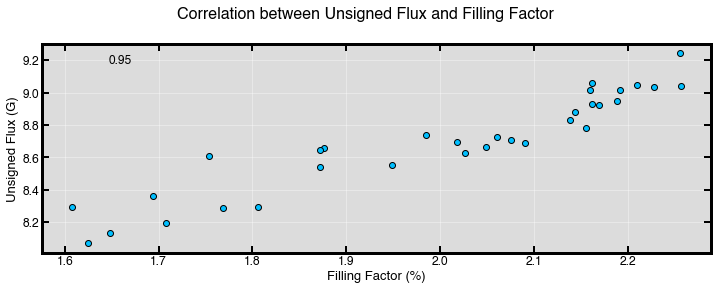

In [824]:
x = g_f
y = g_Bobs
xlabel = 'Filling Factor (%)'
ylabel = 'Unsigned Flux (G)'
title = 'Correlation between Unsigned Flux and Filling Factor'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_f_Bobs.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)

## Filling Factor and NEID RV Comparison

Compare NEID RVs to filling factor.

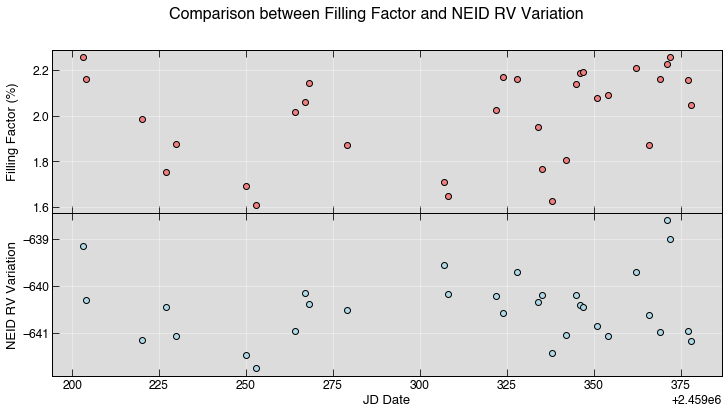

In [825]:
x = g_date_jd
y_list = [g_f, g_rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Filling Factor (%)', 'NEID RV Variation']
title = 'Comparison between Filling Factor and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_f_rvsun.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

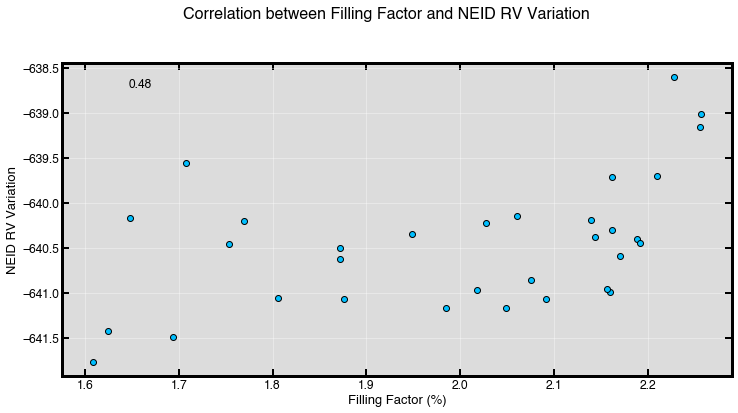

In [826]:
x = g_f
y = g_rv_sun
xlabel = 'Filling Factor (%)'
ylabel = 'NEID RV Variation'
title = 'Correlation between Filling Factor and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_f_rvsun.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)

## Compare NEID RVs to unsigned flux.

Compare NEID RVs to unsigned flux.

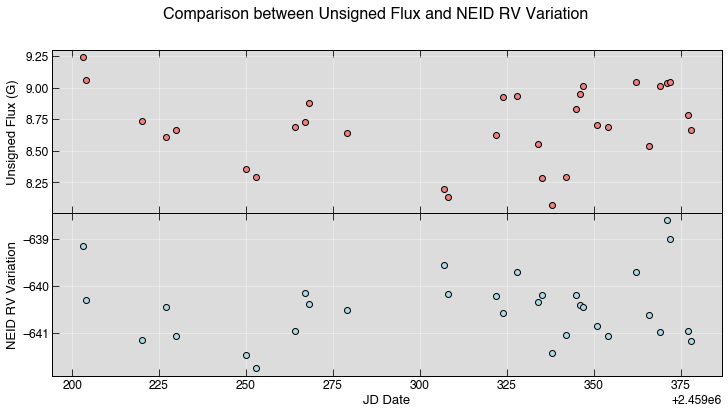

In [827]:
x = g_date_jd
y_list = [g_Bobs, g_rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Unsigned Flux (G)', 'NEID RV Variation']
title = 'Comparison between Unsigned Flux and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_rvsun_Bobs.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)


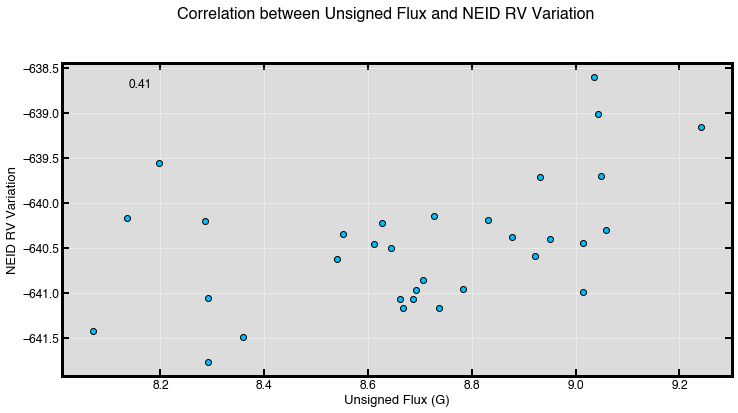

In [828]:
x = g_Bobs
y = g_rv_sun
xlabel = 'Unsigned Flux (G)'
ylabel = 'NEID RV Variation'
title = 'Correlation between Unsigned Flux and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_rvsun_Bobs.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

# Compare with Model RVs


Recalculate model RVs.

In [829]:
# make arrays
X = np.zeros(shape=(len(g_rv_sun), 2))
X[:, 0] = g_v_phot
X[:, 1] = g_v_conv
y = g_rv_sun

# apply regression
reg = LinearRegression(positive=True).fit(X, y)

# get scaling factors
A = reg.coef_[0]
B = reg.coef_[1]
RV0 = reg.intercept_


# # calculate the Model RV for the milbourne data using these coefficients
rv_model_weather = A*g_v_phot + B*g_v_conv + RV0
# component_df["rv_model_weather_cut"] = RV
# component_df.to_csv(csv_file, index=False)

print('A:', A, ', B:', B, ', RV0:', RV0)

A: 0.36267606731534263 , B: 0.5390080280340404 , RV0: -642.4605523701896


## NEID RVs and Model RVs

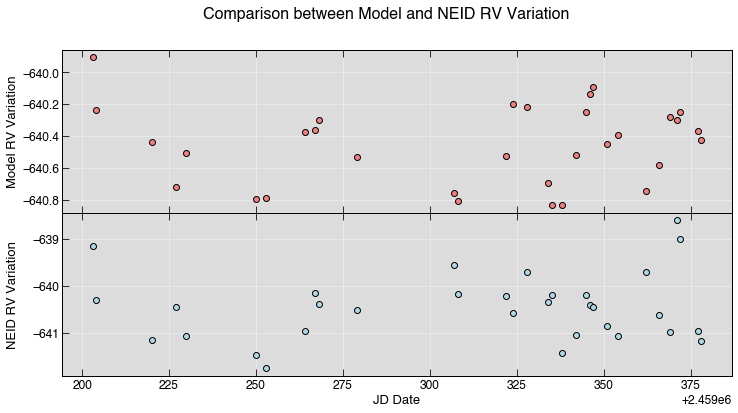

In [830]:
x = g_date_jd
y_list = [rv_model_weather, g_rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'NEID RV Variation']
title = 'Comparison between Model and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_weathermodel_rvsun.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

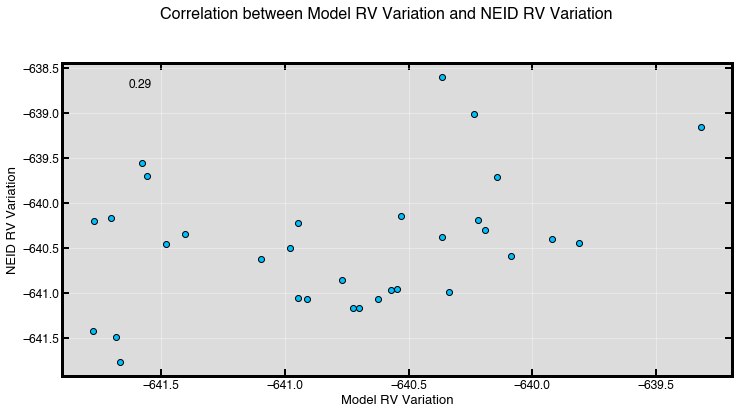

In [831]:
x = g_rv_model
y = g_rv_sun
xlabel = 'Model RV Variation'
ylabel = 'NEID RV Variation'
title = 'Correlation between Model RV Variation and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_rvmodel_rvsun.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)

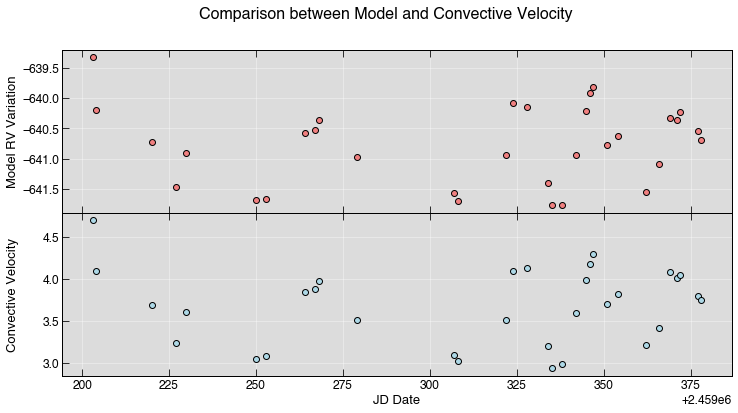

In [832]:
x = g_date_jd
y_list = [g_rv_model, g_v_conv]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'Convective Velocity']
title = 'Comparison between Model and Convective Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_rvmodel_vconv.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

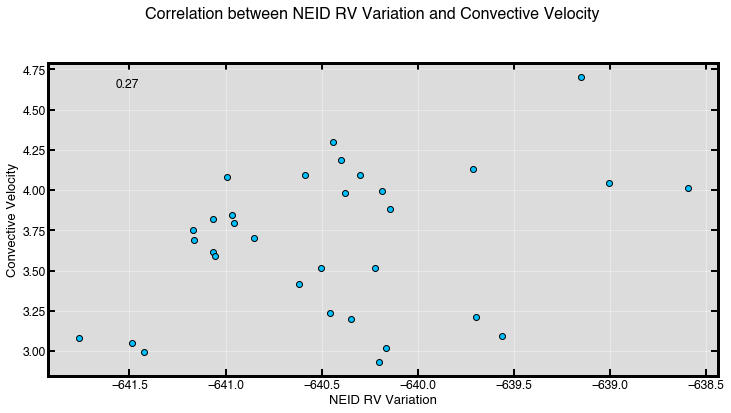

In [833]:
x = g_rv_sun
y = g_v_conv
xlabel = 'NEID RV Variation'
ylabel = 'Convective Velocity'
title = 'Correlation between NEID RV Variation and Convective Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_rvsun_vconv.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)

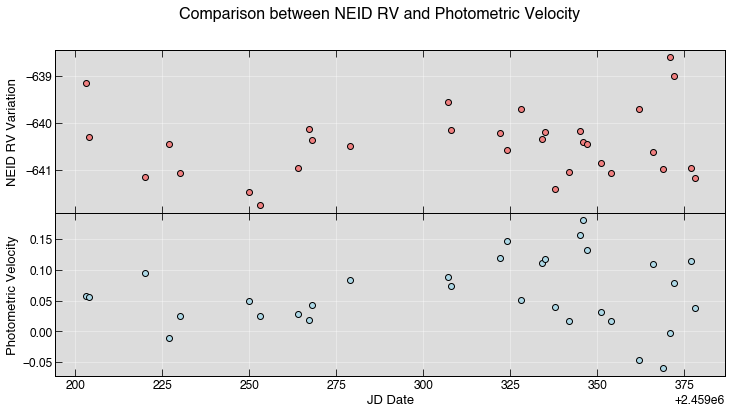

In [834]:
x = g_date_jd
y_list = [g_rv_sun, g_v_phot]
xlabel = 'JD Date'
ylabel_list = ['NEID RV Variation', 'Photometric Velocity']
title = 'Comparison between NEID RV and Photometric Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_rvsun_vphot.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

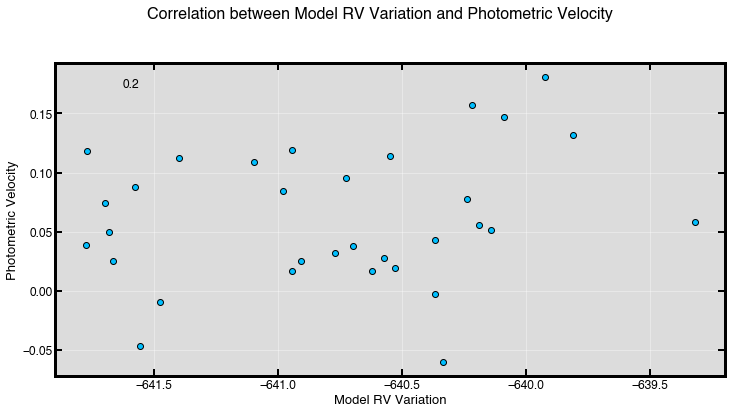

In [835]:
x = g_rv_model
y = g_v_phot
xlabel = 'Model RV Variation'
ylabel = 'Photometric Velocity'
title = 'Correlation between Model RV Variation and Photometric Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_rvmodel_vphot.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)

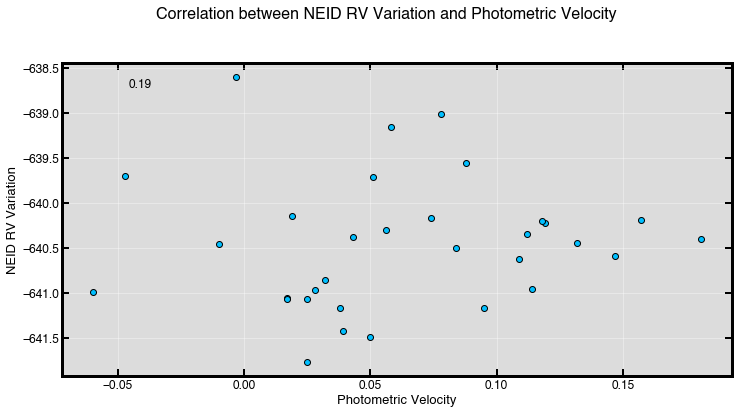

In [836]:
x = g_v_phot
y = g_rv_sun
xlabel = 'Photometric Velocity'
ylabel = 'NEID RV Variation'
title = 'Correlation between NEID RV Variation and Photometric Velocity'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_rvphot_rvsun.png')
plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)

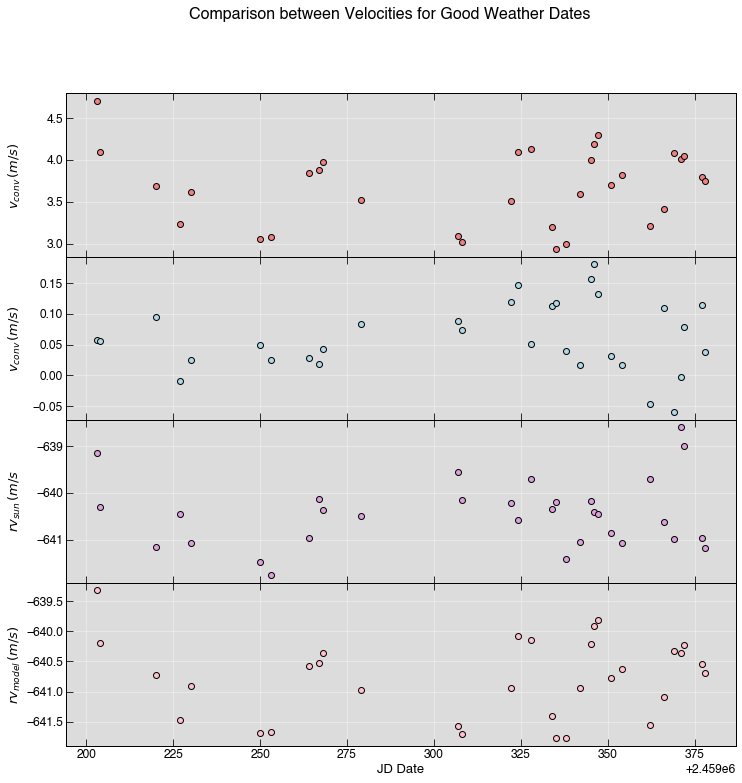

In [837]:
x = g_date_jd
y_list = [g_v_conv, g_v_phot, g_rv_sun, g_rv_model]
xlabel = 'JD Date'
ylabel_list = ['$v_{conv}\/(m/s)$','$v_{conv}\/(m/s)$', '$rv_{sun}\/(m/s})$', '$rv_{model}\/(m/s)$']
title = 'Comparison between Velocities for Good Weather Dates'

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_timeseries_vel.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

## Comparison with observables

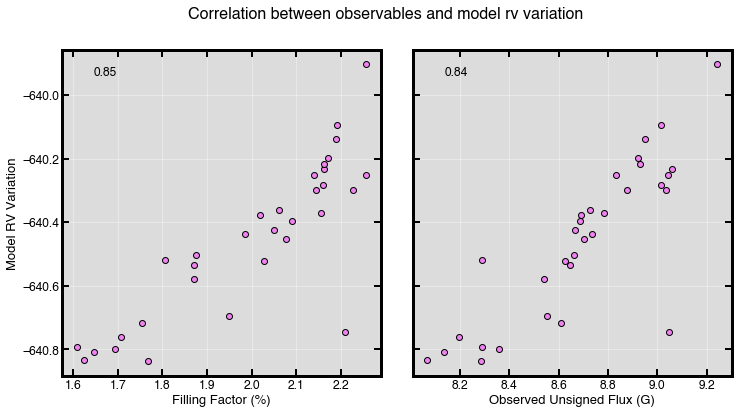

In [838]:
x_list = [g_f, g_Bobs]
y = rv_model_weather
title = 'Correlation between observables and model rv variation'
xlabel_list = ['Filling Factor (%)', 'Observed Unsigned Flux (G)']
ylabel = 'Model RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weather_Bobs_f_weathermodel.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig=None)

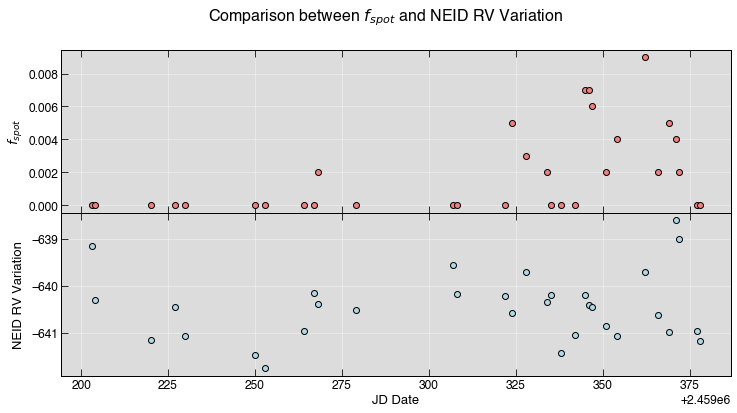

In [839]:
x = g_date_jd
y_list = [g_f_spot, g_rv_sun]
xlabel = 'JD Date'
ylabel_list = ['$f_{spot}$', 'NEID RV Variation']
title = 'Comparison between $f_{spot}$ and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_fspot_rvsun.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

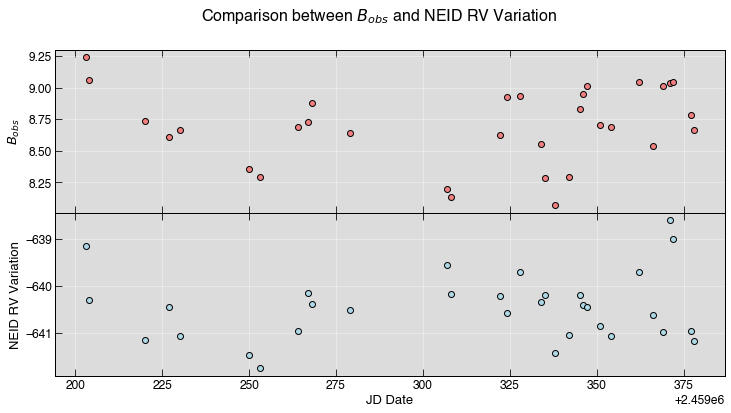

In [840]:
x = g_date_jd
y_list = [g_Bobs, g_rv_sun]
xlabel = 'JD Date'
ylabel_list = ['$B_{obs}$', 'NEID RV Variation']
title = 'Comparison between $B_{obs}$ and NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'timeseries_weather_Bobs_rvsun.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)

## RV and Velocities comparison

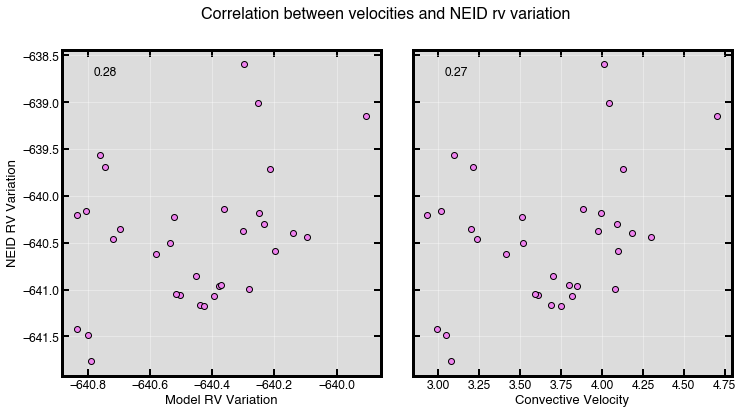

In [841]:
x_list = [rv_model_weather, g_v_conv]
y = g_rv_sun
title = 'Correlation between velocities and NEID rv variation'
xlabel_list = ['Model RV Variation', 'Convective Velocity']
ylabel = 'NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'correlation_weathermodel_vconv_rvsun.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig=None)


## Observables comparison with convective velocity

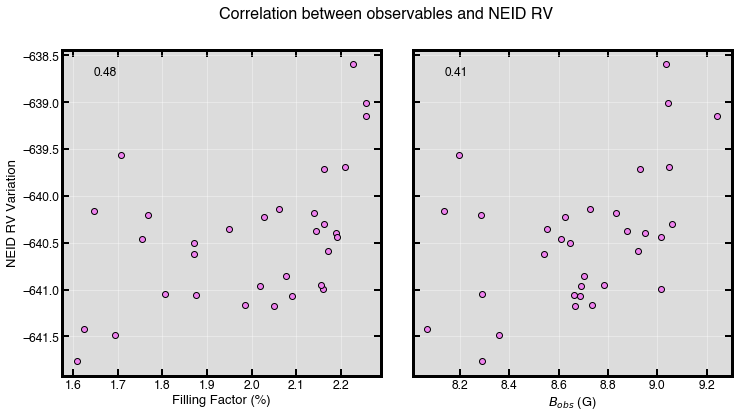

In [842]:
x_list = [g_f, g_Bobs]
y = g_rv_sun
title = 'Correlation between observables and NEID RV'
xlabel_list = ['Filling Factor (%)', '$B_{obs}$ (G)']
ylabel = 'NEID RV Variation'

save_fig = os.path.join(ImgDir.NEID_IMG, 'weather_rvsun_mag.png')
plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)


# Subtract unsigned flux

In [843]:
X = g_Bobs.reshape(-1, 1)
Y = g_rv_sun
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*g_Bobs + b
rv_Bobs = g_rv_sun - fit_line

In [844]:
# arr = np.polyfit(Bobs, rv_sun, 4)
#
# fit_line1 = arr[0]*Bobs**4 + arr[1]*Bobs**3 + arr[2]*Bobs**2 + arr[3]*Bobs + arr[4]
# rv_Bobs = rv_sun - fit_line1

Text(0.5, 1.0, 'Comparison of $B_{obs}$ and NEID RV')

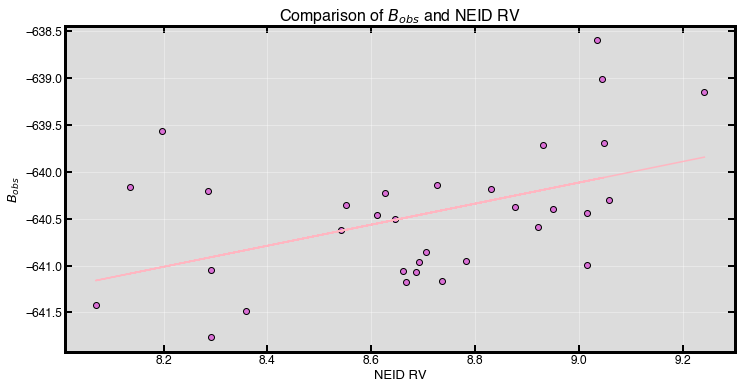

In [845]:
plt.scatter(g_Bobs, g_rv_sun, color='orchid', edgecolor='k', linewidths=1.0)
plt.plot(g_Bobs, fit_line, color='lightpink')
# plt.scatter(Bobs, fit_line1, color='blue')
plt.xlabel('NEID RV')
plt.ylabel('$B_{obs}$')
plt.title('Comparison of $B_{obs}$ and NEID RV')


NEID RV Std: 0.7167683363252988
Edited RV Std: 0.6333918339213903


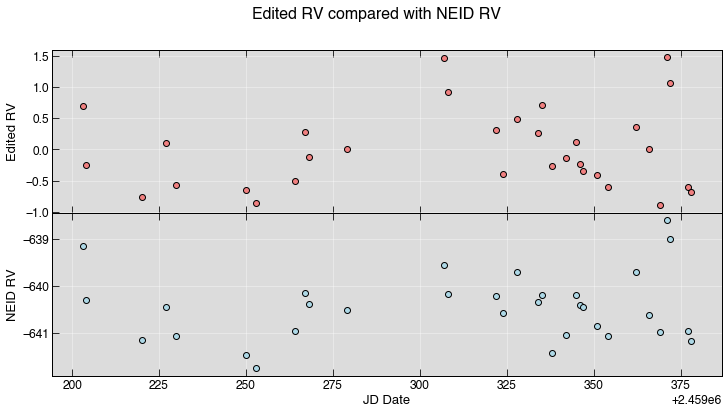

In [846]:
x = g_date_jd
y_list = [rv_Bobs, g_rv_sun]
title = 'Edited RV compared with NEID RV'
xlabel = 'JD Date'
ylabel_list = ['Edited RV', 'NEID RV']

save_fig = os.path.join(ImgDir.NEID_IMG, 'edited_rvs_Bobs.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
print("NEID RV Std:", np.std(g_rv_sun))
print("Edited RV Std:", np.std(rv_Bobs))

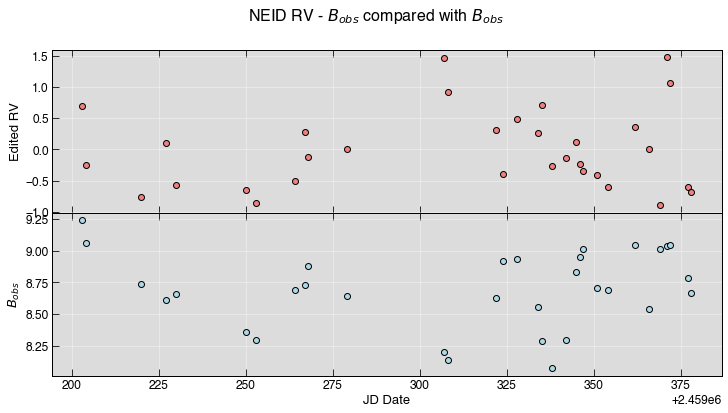

In [847]:
x = g_date_jd
y_list = [rv_Bobs, g_Bobs]
title = 'NEID RV - $B_{obs}$ compared with $B_{obs}$'
xlabel = 'JD Date'
ylabel_list = ['Edited RV', '$B_{obs}$']

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list)


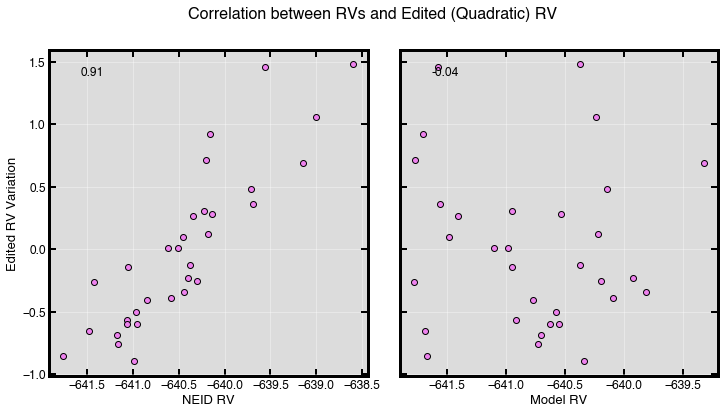

In [848]:
x_list = [g_rv_sun, g_rv_model]
y = rv_Bobs
title = 'Correlation between RVs and Edited (Quadratic) RV'
xlabel_list = ['NEID RV', 'Model RV']
ylabel = 'Edited RV Variation'

plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig=None)


Get new model RV based on edited RV.

In [849]:
# make arrays
X = np.zeros(shape=(len(g_rv_sun), 2))
X[:, 0] = g_v_phot
X[:, 1] = g_v_conv
y = rv_Bobs - np.min(rv_Bobs)

# apply regression
reg = LinearRegression(positive=True).fit(X, y)

# get scaling factors
A = reg.coef_[0]
B = reg.coef_[1]
RV0 = reg.intercept_

# # calculate the Model RV for the milbourne data using these coefficients
rv_model_weather = A*g_v_phot + B*g_v_conv + RV0

print('A:', A, ', B:', B, ', RV0:', RV0)


A: 1.0415557961676116 , B: 0.0 , RV0: 0.8292737073182056


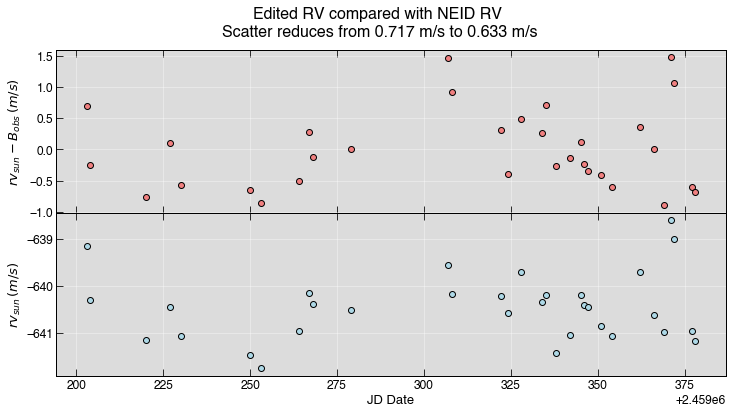

In [850]:
x = g_date_jd
y_list = [rv_Bobs, g_rv_sun]
title = 'Edited RV compared with NEID RV \nScatter reduces from ' + str(np.round(np.std(g_rv_sun), 3)) + ' m/s to ' + str(np.round(np.std(rv_Bobs), 3)) + ' m/s'
xlabel = 'JD Date'
ylabel_list = ['$rv_{sun} - B_{obs} \/(m/s)$', '$rv_{sun} \/(m/s)$']

save_fig = os.path.join(ImgDir.NEID_IMG, 'edited_rvs_Bobs.png')
plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)


In [851]:
print(np.std(rv_Bobs))
print(np.std(g_rv_sun))


0.6333918339213903
0.7167683363252988


# Other plotting stuff (ignore)

# Remove NEID and Magnetic Observable Outliers

Remove NEID outliers.

max_ind = np.argmax(rv_sun)
rv_sun[max_ind] = (rv_sun[max_ind-1] + rv_sun[max_ind+1])/2

Remove magnetic outliers.

max_ind = np.argmax(f)
f[max_ind] = (f[max_ind-1] + f[max_ind+1])/2

max_ind = np.argmax(Bobs)
Bobs[max_ind] = (Bobs[max_ind-1] + Bobs[max_ind+1])/2

## Plotting without outliers

x = date_jd
y_list = [f, Bobs]
xlabel = 'JD Date'
ylabel_list = ['Filling Factor (%)', 'Unsigned Flux (G)']
title = 'Comparison between Unsigned Flux and Filling Factor'
# # save_fig = /Users/tervin/images/neid_long/timeseries_f_Bobs.png'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

Correlation plot between unsigned flux and filling factor.

x = f
y = Bobs
xlabel = 'Filling Factor (%)'
ylabel = 'Unsigned Flux (G)'
title = 'Correlation between Unsigned Flux and Filling Factor'
# # save_fig = /Users/tervin/images/neid_long/correlation_f_Bobs.png'

plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

## Filling Factor and NEID RV Comparison

Compare NEID RVs to filling factor.

x = date_jd
y_list = [f, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Filling Factor (%)', 'NEID RV Variation']
title = 'Comparison between Filling Factor and NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/timeseries_rvsun_f.png'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

x = f
y = rv_sun
xlabel = 'Filling Factor (%)'
ylabel = 'NEID RV Variation'
title = 'Correlation between Filling Factor and NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/correlation_rvsun_f.png'

plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

## Compare NEID RVs to unsigned flux.

Compare NEID RVs to unsigned flux.

x = date_jd
y_list = [Bobs, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Unsigned Flux (G)', 'NEID RV Variation']
title = 'Comparison between Unsigned Flux and NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/timeseries_rvsun_Bobs.png'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig=None

x = Bobs
y = rv_sun
xlabel = 'Unsigned Flux (G)'
ylabel = 'NEID RV Variation'
title = 'Correlation between Unsigned Flux and NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/correlation_rvsun_Bobs.png'

plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

# Compare with Model RVs

## NEID RVs and Model RVs

x = date_jd
y_list = [rv_model, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'NEID RV Variation']
title = 'Comparison between Model and NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/timeseries_rvmodel_rvsun.png'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

x = date_jd
y_list = [rv_model, v_conv]
xlabel = 'JD Date'
ylabel_list = ['Model RV Variation', 'Convective Velocity']
title = 'Comparison between Model and Convective Velocity'
# # save_fig = /Users/tervin/images/neid_long/timeseries_rvmodel_vconv.png'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

x = rv_model
y = v_conv
xlabel = 'Model RV Variation'
ylabel = 'Convective Velocity'
title = 'Correlation between Model RV Variation and Convective Velocity'
# # save_fig = /Users/tervin/images/neid_long/correlation_rvmodel_vconv.png'

plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

x = date_jd
y_list = [rv_sun, v_conv]
xlabel = 'JD Date'
ylabel_list = ['NEID RV Variation', 'Convective Velocity']
title = 'Comparison between NEID RV and Convective Velocity'
# # save_fig = /Users/tervin/images/neid_long/timeseries_rvsun_vconv.png'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list, save_fig)
save_fig = None

x = rv_model
y = rv_sun
xlabel = 'Model RV Variation'
ylabel = 'NEID RV Variation'
title = 'Correlation between Unsigned Flux and NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/correlation_rvmodel_rvsun.png'

plot.correlation_plot(x, y, title, xlabel, ylabel, save_fig)
save_fig = None

## Comparison with observables

x_list = [f, Bobs]
y = rv_model
title = 'Correlation between observables and model RV variation'
xlabel_list = ['Filling Factor (%)', 'Observed Unsigned Flux (G)']
ylabel = 'Model RV Variation'
# # save_fig = /Users/tervin/images/neid_long/correlation_rvmodel_f_Bobs.png'

plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

## RV and Velocities comparison

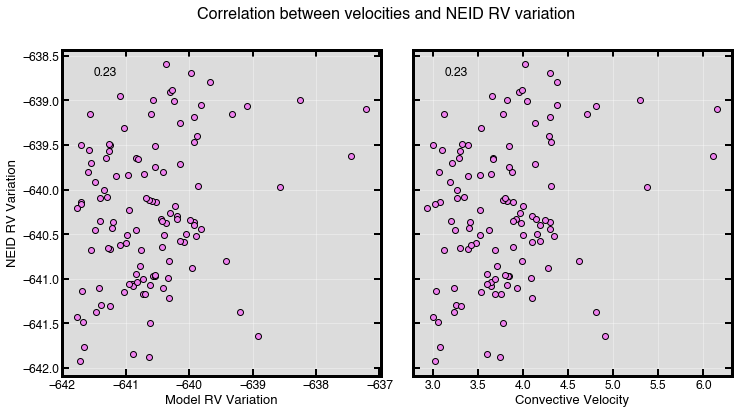

In [852]:
x_list = [rv_model, v_conv]
y = rv_sun
title = 'Correlation between velocities and NEID RV variation'
xlabel_list = ['Model RV Variation', 'Convective Velocity']
ylabel = 'NEID RV Variation'
# # save_fig = /Users/tervin/images/neid_long/correlation_rvsun_rvmodel_vconv.png'

plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig=None)
save_fig = None

## Observables comparison with convective velocity

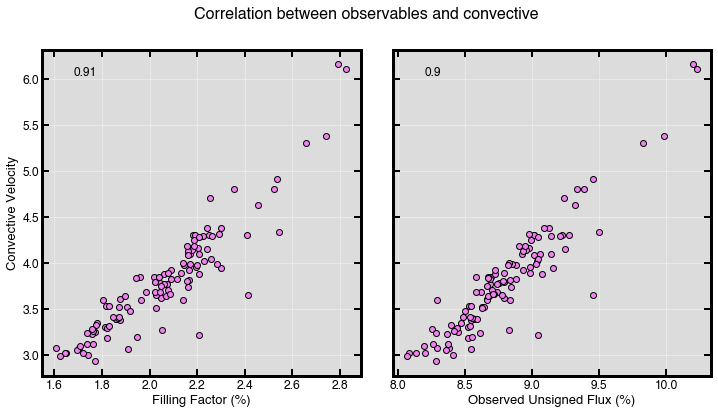

In [853]:
x_list = [f, Bobs]
y = v_conv
title = 'Correlation between observables and convective'
xlabel_list = ['Filling Factor (%)', 'Observed Unsigned Flux (%)']
ylabel = 'Convective Velocity'
# # save_fig = /Users/tervin/images/neid_long/correlation_vconv_f_Bobs.png'

plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel, save_fig)
save_fig = None

Overplotting of RVs

In [854]:
x = date_jd
y_list = [rv_sun, rv_model]
xlabel = 'JD Date'
ylabel = 'RV Sun & RV Model'
title = 'Comparison of RV from NEID and Model'

# # save_fig = /Users/tervin/images/neid_long/timeseries_rv_overlay.png'

# plot.plot_overlaid_timeseries(x, y_list, title, xlabel, ylabel, save_fig)
save_fig = None

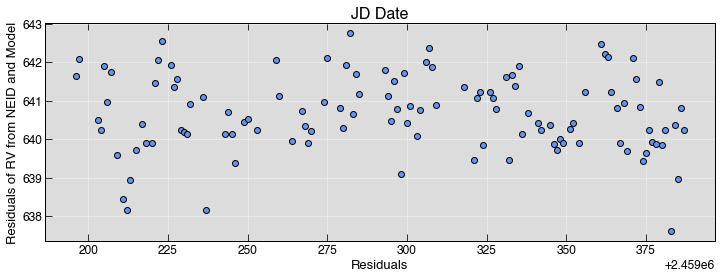

In [855]:
x = date_jd
y = rv_sun - rv_model - np.median(rv_sun)
xlabel = 'JD Date'
ylabel = 'Residuals'
title = 'Residuals of RV from NEID and Model'

# # save_fig = /Users/tervin/images/neid_long/timeseries_rv_residuals.png'
plot.plot_timeseries(x, y, xlabel, ylabel, title, save_fig)
save_fig = None

